In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime
import random
import math
import json

# 生产测试数据

In [3]:
# 生成测试数据
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2023, 1, 10)
symbols = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']

# 创建时间序列(分钟频) 09:30-15:00 每分钟一条数据
time_deltas = []
start_minutes = 9 * 60 + 30  # 09:30
end_minutes = 15 * 60  # 15:00
for minutes in range(start_minutes, end_minutes):
    time_deltas.append(datetime.timedelta(minutes=minutes))

dates = pd.date_range(start_date, end_date, freq='D')

# 生成DataFrame
data = []
for date in dates:
    for delta in time_deltas:
        for symbol in symbols:
            close = random.uniform(100, 500)
            open_p = close * random.uniform(0.99, 1.01)
            high = max(open_p, close) * random.uniform(1.0, 1.02)
            low = min(open_p, close) * random.uniform(0.98, 1.0)
            weight = 1 / len(symbols)
            
            # 计算涨跌幅
            pct_change = (close - open_p) / open_p * 100
            
            # 随机生成是否ST股票(5%概率)
            is_st = random.random() < 0.05
            
            # 计算是否跌停(跌幅超过9.5%且不是ST股)
            is_limit_down = (pct_change <= -9.5) and (not is_st)
            
            # 计算是否涨停(涨幅超过9.5%且不是ST股)
            is_limit_up = (pct_change >= 9.5) and (not is_st)
            
            data.append({
                'date': date,
                'time': delta,
                'symbol': symbol,
                'close': close,
                'open': open_p,
                'high': high,
                'low': low,
                'weights': weight,
                'pct_change': pct_change,  # 涨跌幅(%)
                'is_st': is_st,  # 是否ST股票
                'is_limit_down': is_limit_down,  # 是否跌停
                'is_limit_up': is_limit_up  # 是否涨停
            })

df = pd.DataFrame(data)
print(f"生成数据形状: {df.shape}")
df.head()

生成数据形状: (16500, 12)


,date,time,symbol,close,open,high,low,weights,pct_change,is_st,is_limit_down,is_limit_up
0,2023-01-01,0 days 09:30:00,AAPL,496.466676,499.896621,506.757559,492.859936,0.2,-0.686131,False,False,False
1,2023-01-01,0 days 09:30:00,MSFT,409.465194,412.918412,414.726433,403.371324,0.2,-0.836295,False,False,False
2,2023-01-01,0 days 09:30:00,GOOG,430.772231,432.356827,436.024257,426.015090,0.2,-0.366502,False,False,False
3,2023-01-01,0 days 09:30:00,AMZN,207.241149,205.444903,209.773414,205.181530,0.2,0.874320,False,False,False
4,2023-01-01,0 days 09:30:00,TSLA,261.372658,263.969499,267.083692,260.496322,0.2,-0.983766,False,False,False


In [4]:
# 生成测试数据 - 使用更真实的价格和波动模式
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2023, 1, 10)
symbols = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']

# 创建时间序列(分钟频) 09:30-15:00 每分钟一条数据
time_deltas = []
start_minutes = 9 * 60 + 30  # 09:30
end_minutes = 15 * 60  # 15:00
for minutes in range(start_minutes, end_minutes):
    time_deltas.append(datetime.timedelta(minutes=minutes))

dates = pd.date_range(start_date, end_date, freq='D')

# 设置各股票基准价格
base_prices = {
    'AAPL': 150.0,
    'MSFT': 300.0,
    'GOOG': 100.0,
    'AMZN': 100.0,
    'TSLA': 200.0
}

# 生成DataFrame
data = []
for date in dates:
    # 每日初始价格
    daily_bases = {sym: base_prices[sym] * (0.95 + 0.1 * random.random()) for sym in symbols}
    
    for delta in time_deltas:
        for symbol in symbols:
            # 更真实的随机游走价格生成
            prev_close = daily_bases[symbol] if delta.total_seconds() == 570*60 else data[-1]['close']
            
            # 价格波动更符合实际市场(更小的日内波动)
            pct_change = random.gauss(0, 0.001)  # 均值0, 标准差0.1%
            close = prev_close * (1 + pct_change)
            
            # 开盘价基于前收盘价
            open_p = prev_close * (0.999 + 0.002 * random.random())
            
            # 高低价更合理
            high = max(open_p, close) * (1.000 + 0.001 * random.random())
            low = min(open_p, close) * (0.999 + 0.001 * random.random())
            
            weight = 1 / len(symbols)
            pct_change = (close - open_p) / open_p * 100
            
            # ST股票概率降低到1%
            is_st = random.random() < 0.01
            
            # 涨跌停概率更真实(0.5%)
            is_limit_down = (pct_change <= -9.5) and (not is_st) and (random.random() < 0.005)
            is_limit_up = (pct_change >= 9.5) and (not is_st) and (random.random() < 0.005)
            
            data.append({
                'date': date,
                'time': delta,
                'symbol': symbol,
                'close': close,
                'open': open_p,
                'high': high,
                'low': low,
                'weights': weight,
                'pct_change': pct_change,
                'is_st': is_st,
                'is_limit_down': is_limit_down,
                'is_limit_up': is_limit_up
            })
            
            # 更新基准价格
            daily_bases[symbol] = close

df = pd.DataFrame(data)
print(f"生成数据形状: {df.shape}")
df.head()

生成数据形状: (16500, 12)


,date,time,symbol,close,open,high,low,weights,pct_change,is_st,is_limit_down,is_limit_up
0,2023-01-01,0 days 09:30:00,AAPL,151.826035,151.636476,151.880753,151.498056,0.2,0.125009,False,False,False
1,2023-01-01,0 days 09:30:00,MSFT,287.066815,287.073693,287.194584,286.926691,0.2,-0.002396,False,False,False
2,2023-01-01,0 days 09:30:00,GOOG,97.161260,97.140489,97.230013,97.096354,0.2,0.021382,False,False,False
3,2023-01-01,0 days 09:30:00,AMZN,96.147356,95.993895,96.236189,95.920446,0.2,0.159866,False,False,False
4,2023-01-01,0 days 09:30:00,TSLA,205.548121,205.453461,205.721491,205.253557,0.2,0.046074,False,False,False


# 优化器模拟


=== 第1轮优化 ===
当前组合市值: 101401.00962335034
初始组合市值: 101401.00962335034
预测收益: [ 0.0333  0.0121 -0.064   0.0092 -0.01  ]
当前持仓: [0.2609 0.1493 0.152  0.2312 0.2066]
优化权重: [0.3009 0.1893 0.112  0.2312 0.1666]
权重变化: [ 0.04  0.04 -0.04  0.   -0.04]
最新权重和: 1.0
本轮交易初始组合比例: [0.1533 0.268  0.2631 0.     0.1936]
累计交易初始组合比例: [0.1533 0.268  0.2631 0.     0.1936]
初始持仓最新权重: [0.2609 0.1493 0.152  0.2312 0.2066]

=== 第2轮优化 ===
当前组合市值: 103058.19250666483
初始组合市值: 102717.40566944335
预测收益: [ 0.0076 -0.0158 -0.0464  0.0041  0.0855]
当前持仓: [0.3144 0.183  0.1    0.2298 0.1727]
优化权重: [0.3544 0.143  0.06   0.2298 0.2127]
权重变化: [ 0.04 -0.04 -0.04  0.    0.04]
最新权重和: 1.0
本轮交易初始组合比例: [0.1467 0.2771 0.2948 0.     0.1867]
累计交易初始组合比例: [0.3001 0.545  0.5579 0.     0.3804]
初始持仓最新权重: [0.2735 0.1448 0.1361 0.2306 0.2149]

=== 第3轮优化 ===
当前组合市值: 104312.14953154526
初始组合市值: 103851.91633079197
预测收益: [-0.0451  0.0614 -0.0332  0.0156  0.0152]
当前持仓: [0.3663 0.1386 0.0613 0.2261 0.2076]
优化权重: [0.3263 0.1786 0.0213 0.2661 0.2076]
权重变

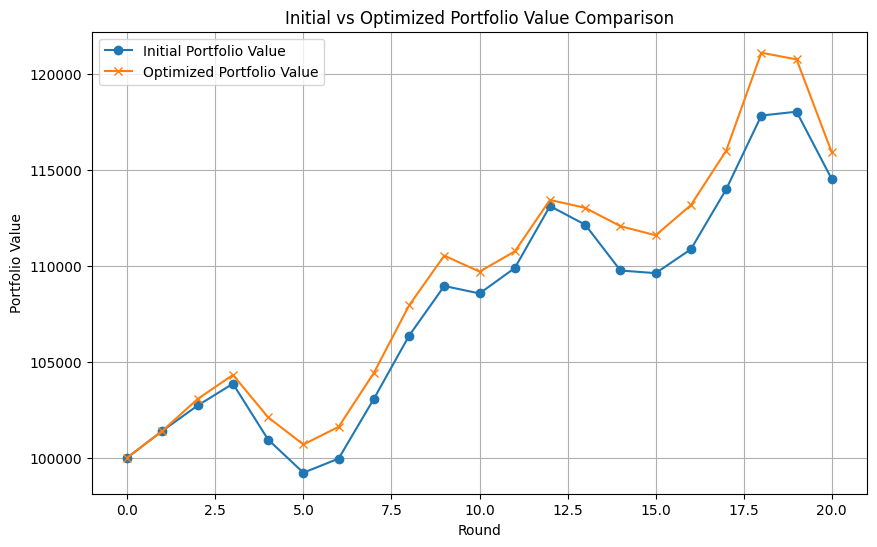

In [5]:
# 使用cvxpy实现的优化器模块
import cvxpy as cp
import numpy as np

class PortfolioOptimizer:
    def __init__(self):
        """
        初始化优化器
        """
        pass
    
    def optimize(self, w0, alpha, max_trade_pct, initial_weights=None, cumulative_trades=None, optimizable_mask=None, cost_func=None, lambda_cost=0.01, max_turnover_ratio=1.0, current_portfolio_value=1.0, initial_portfolio_value=1.0):
        """
        执行投资组合优化
        :param w0: 当前权重 (numpy array)
        :param alpha: 预测收益序列 (numpy array)
        :param max_trade_pct: 最大可交易量向量 (numpy array)
        :param initial_weights: 当日初始持仓权重 (numpy array)
        :param cumulative_trades: 当日累计交易占初始持仓比例 (numpy array)
        :param max_turnover_ratio: 最大累计交易比例阈值 (默认1.0)
        :param current_portfolio_value: 当前组合市值
        :param initial_portfolio_value: 初始持仓组合市值
        
        :param optimizable_mask: 可优化标记 (numpy bool array), True表示可优化,False表示保持原权重
        :param cost_func: 交易成本函数 (可选)
        :param lambda_cost: 交易成本惩罚系数 (默认0.01), 模拟滑点成本
        :return: 优化后的权重 w_opt
        """
        n = len(w0)
        
        # 默认所有资产都可优化
        if optimizable_mask is None:
            optimizable_mask = np.ones(n, dtype=bool)
            
        # 默认初始持仓权重等于当前权重
        if initial_weights is None:
            initial_weights = w0.copy()
            
        # 默认累计交易为0
        if cumulative_trades is None:
            cumulative_trades = np.zeros(n)
        
        # 定义优化变量
        w = cp.Variable(n)
        
        # 权重变化量
        dw = w - w0
        
        # 计算交易金额变化比例
        trade_ratio = cp.abs(dw) * current_portfolio_value / (initial_weights * initial_portfolio_value)

        # 默认线性交易成本函数
        if cost_func is None:
            cost = cp.norm(dw, 1)  # L1范数作为交易成本
        else:
            cost = cost_func(dw)
        
        # 目标函数: 最大化收益减去交易成本
        objective = cp.Maximize(dw @ alpha - lambda_cost * cost)
        
        # 约束条件
        constraints = [
            cp.sum(w) == 1,  # 权重和为1
            w >= 0,  # 权重非负
            w <= 1,  # 权重不超过1
            cp.abs(dw) <= max_trade_pct,  # 交易量限制
            # 累计交易比例不超过max_turnover_ratio
            trade_ratio + cumulative_trades <= max_turnover_ratio
        ]
        # 当有不可优化资产时添加约束，保持不可优化资产权重不变
        if not np.all(optimizable_mask):
            constraints.append(cp.sum(w[~optimizable_mask]) == cp.sum(w0[~optimizable_mask]))
        
        # 构建并求解问题
        problem = cp.Problem(objective, constraints)
        problem.solve()
        
        if problem.status != 'optimal':
            raise ValueError("优化失败, 状态: " + problem.status)
            
        return w.value

# 测试优化器
if __name__ == "__main__":
    # 初始化参数
    initial_weights = np.array([0.25, 0.15, 0.15, 0.25, 0.2])  # 初始持仓权重
    initial_portfolio_value = 100000  # 初始组合市值
    max_trade_pct = np.array([1/25] * 5)  # 最大交易量
    optimizable = np.array([True, True, True, True, True])  # 可优化标记
    
    # 初始化状态变量
    w0 = initial_weights.copy()  # 当前持仓
    cumulative_trades = np.zeros(5)  # 累计交易比例
    current_value = initial_portfolio_value  # 当前市值
    prev_value = initial_portfolio_value  # 上一轮市值
    
    # 初始化市值曲线存储
    initial_values = [initial_portfolio_value]
    current_values = [current_value]
    
    # 初始化预测收益
    alpha = np.random.uniform(-0.1, 0.1, 5)  # 预测收益

    # 模拟10轮优化
    for round in range(1, 21):
        print(f"\n=== 第{round}轮优化 ===")
        
        # 随机生成alpha模拟市场变化
        price_change = 0.2 * alpha + 0.8 * np.random.uniform(-0.1, 0.1, 5)  # 70%被alpha预测，30%随机噪声
        alpha = np.random.uniform(-0.1, 0.1, 5)  # 预测下一轮收益

        # 更新当前市值(基于权重和股价变化)
        current_value = prev_value * (1 + w0 @ price_change)
        # 更新初始组合市值(同样基于权重和股价变化)
        initial_portfolio_value = initial_portfolio_value * (1 + initial_weights @ price_change)
        
        # 动态更新初始权重(基于市值变化)
        initial_weights = initial_weights * (1 + price_change)
        initial_weights /= np.sum(initial_weights)  # 重新归一化
        
        # 动态更新w0
        w0 = w0 * (1 + price_change)
        w0 /= np.sum(w0)  # 重新归一化

        optimizer = PortfolioOptimizer()
        w_opt = optimizer.optimize(w0, alpha, max_trade_pct, initial_weights, cumulative_trades,
                                 optimizable, current_portfolio_value=current_value,
                                 initial_portfolio_value=initial_portfolio_value)
        
        # 计算本轮交易
        trade_amount = np.abs(w_opt - w0) * current_value / (initial_weights * initial_portfolio_value)
        
        print("当前组合市值:", current_value)
        print("初始组合市值:", initial_portfolio_value)
        print("预测收益:", np.round(alpha, 4))
        print("当前持仓:", np.round(w0, 4))
        print("优化权重:", np.round(w_opt, 4))
        print("权重变化:", np.round(w_opt - w0, 4))
        print("最新权重和:", np.round(np.sum(w_opt), 4))
        print("本轮交易初始组合比例:", np.round(trade_amount, 4))
        print("累计交易初始组合比例:", np.round(cumulative_trades + trade_amount, 4))
        print("初始持仓最新权重:", np.round(initial_weights, 4))

        
        # 更新状态变量
        w0 = w_opt.copy()
        cumulative_trades += trade_amount
        prev_value = current_value  # 保存当前市值作为下一轮的参考
        
        # 在每轮循环结束时更新市值曲线数据
        initial_values.append(initial_portfolio_value)
        current_values.append(current_value)
        
    # 在模拟循环结束后绘制市值曲线
    plt.figure(figsize=(10, 6))
    plt.plot(range(21), initial_values, label='Initial Portfolio Value', marker='o')
    plt.plot(range(21), current_values, label='Optimized Portfolio Value', marker='x')
    plt.xlabel('Round')
    plt.ylabel('Portfolio Value')
    plt.title('Initial vs Optimized Portfolio Value Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

# 实践应用

In [ ]:
# Pivot the DataFrame to get wide format for necessary features
df['datetime'] = df['date'] + df['time']
df.set_index(['datetime', 'symbol'], inplace=True)

close_pivot = df['close'].unstack()
open_pivot = df['open'].unstack()
high_pivot = df['high'].unstack()
low_pivot = df['low'].unstack()
is_limit_up_pivot = df['is_limit_up'].unstack()
is_limit_down_pivot = df['is_limit_down'].unstack()
is_st_pivot = df['is_st'].unstack()

# Calculate returns for alpha (using next period's return as prediction)
returns = close_pivot.pct_change().shift(-1)
alpha_pivot = returns  # Using next period's return as alpha prediction

In [7]:
n_symbols = len(symbols)
optimizer = PortfolioOptimizer()

# Initial parameters
initial_weights = np.ones(n_symbols) / n_symbols
w0 = initial_weights.copy()
cumulative_trades = np.zeros(n_symbols)
portfolio_value = 1.0
max_trade_pct = np.full(n_symbols, 0.01)  # 1% max trade per asset

In [23]:
portfolio_values = [portfolio_value]
optimized_weights = []

# Initialize buy-and-hold portfolio
buy_and_hold_value = initial_portfolio_value
buy_and_hold_weights = initial_weights.copy()
buy_and_hold_values = [buy_and_hold_value]
buy_and_hold_weights_history = [buy_and_hold_weights.copy()]  # 新增: 记录buy_and_hold权重历史
buy_and_hold_trades = np.zeros(n_symbols)  # 新增: 记录buy_and_hold交易量

# 获取排序后的时间戳
timestamps = close_pivot.index.sort_values()

for i in range(len(timestamps) - 1):  # 停止在倒数第二个时间戳
    current_time = timestamps[i]
    next_time = timestamps[i+1]
    print(current_time)
    
    # 检查是否是新的一天(重置累计交易)
    if current_time.date() != next_time.date():
        cumulative_trades = np.zeros(n_symbols)
        initial_weights = w0.copy()
        initial_portfolio_value = portfolio_value
        
        # At last minute of day: reset to initial weights
        w0 = initial_weights.copy()  # Reset to initial weights for next day
        print(f"在 {current_time} 重置仓位至初始权重")
        
        # 新增: 重置buy_and_hold交易量
        buy_and_hold_trades = np.zeros(n_symbols)

    # 获取当前alpha预测
    alpha = alpha_pivot.loc[current_time].values
    
    # 获取当前是否ST股票或者涨跌停 暂时先统一认为st/涨跌停,不可优化(实际处理方式略有差异，st应当将仓位直接设置为0)
    optimizable = is_limit_up_pivot.loc[current_time].values | is_limit_down_pivot.loc[current_time].values | is_st_pivot.loc[current_time].values

    # 获取当前价格
    current_prices = close_pivot.loc[current_time].values
    
    try:
        # 运行优化
        w_opt = optimizer.optimize(
            w0=w0,
            alpha=alpha,
            max_trade_pct=max_trade_pct,
            initial_weights=initial_weights,
            cumulative_trades=cumulative_trades,
            optimizable_mask=optimizable,
            current_portfolio_value=portfolio_value,
            initial_portfolio_value=initial_portfolio_value
        )
        
        # 计算交易比例
        trade_ratio = np.abs(w_opt - w0) * portfolio_value / (initial_weights * initial_portfolio_value)
        cumulative_trades += trade_ratio
        
        # 更新下一期的组合价值
        next_prices = close_pivot.loc[next_time].values
        returns = (next_prices - current_prices) / current_prices
        portfolio_value *= (1 + np.dot(w_opt, returns))
        
        # 基于价格变化更新Buy-and-Hold仓位
        buy_and_hold_value *= (1 + np.dot(buy_and_hold_weights, returns))
        buy_and_hold_values.append(buy_and_hold_value)
        
        # 新增: 记录buy_and_hold权重变化
        buy_and_hold_weights = buy_and_hold_weights * (1 + returns)
        buy_and_hold_weights /= buy_and_hold_weights.sum()
        buy_and_hold_weights_history.append(buy_and_hold_weights.copy())
        
        # 新增: 计算buy_and_hold交易量
        if i > 0:
            buy_and_hold_trades += np.abs(buy_and_hold_weights - buy_and_hold_weights_history[-2])

        # 基于价格变化更新权重
        w0 = w_opt * (1 + returns)
        w0 /= w0.sum()  # 重新归一化
        
    except ValueError as e:
        print(f"在时间 {current_time} 优化失败: {str(e)}")
        w_opt = w0.copy()  # 使用当前权重作为回退
    
    # 存储结果
    portfolio_values.append(portfolio_value)
    optimized_weights.append(w_opt)

2023-01-01 09:30:00
2023-01-01 09:31:00
2023-01-01 09:32:00
2023-01-01 09:33:00
2023-01-01 09:34:00
2023-01-01 09:35:00
2023-01-01 09:36:00
2023-01-01 09:37:00
2023-01-01 09:38:00
2023-01-01 09:39:00
2023-01-01 09:40:00
2023-01-01 09:41:00
2023-01-01 09:42:00
2023-01-01 09:43:00
2023-01-01 09:44:00
2023-01-01 09:45:00
2023-01-01 09:46:00
2023-01-01 09:47:00
2023-01-01 09:48:00
2023-01-01 09:49:00
2023-01-01 09:50:00
2023-01-01 09:51:00
2023-01-01 09:52:00
2023-01-01 09:53:00
2023-01-01 09:54:00
2023-01-01 09:55:00
2023-01-01 09:56:00
2023-01-01 09:57:00
2023-01-01 09:58:00
2023-01-01 09:59:00
2023-01-01 10:00:00
2023-01-01 10:01:00
2023-01-01 10:02:00
2023-01-01 10:03:00
2023-01-01 10:04:00
2023-01-01 10:05:00
2023-01-01 10:06:00
2023-01-01 10:07:00
2023-01-01 10:08:00
2023-01-01 10:09:00
2023-01-01 10:10:00
2023-01-01 10:11:00
2023-01-01 10:12:00
2023-01-01 10:13:00
2023-01-01 10:14:00
2023-01-01 10:15:00
2023-01-01 10:16:00
2023-01-01 10:17:00
2023-01-01 10:18:00
2023-01-01 10:19:00


<Axes: xlabel='datetime'>

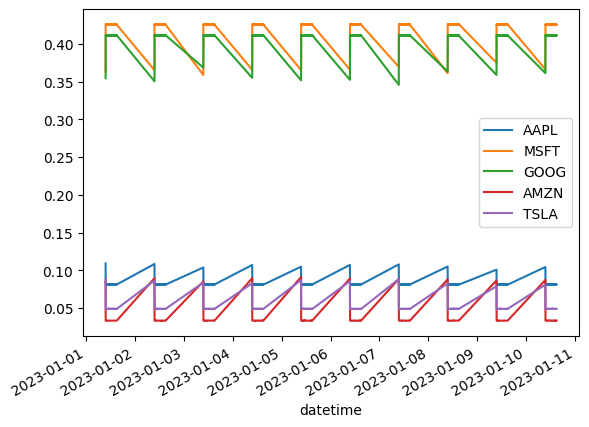

In [24]:
pd.DataFrame(buy_and_hold_weights_history,index=timestamps,columns=symbols).plot()

<Axes: xlabel='datetime'>

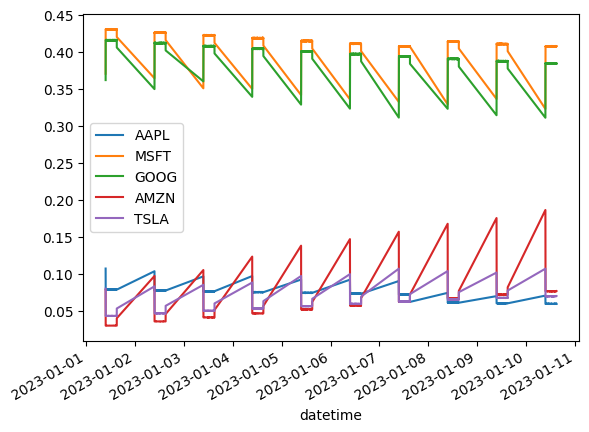

In [25]:
pd.DataFrame(optimized_weights,index=timestamps[:-1],columns=symbols).plot()

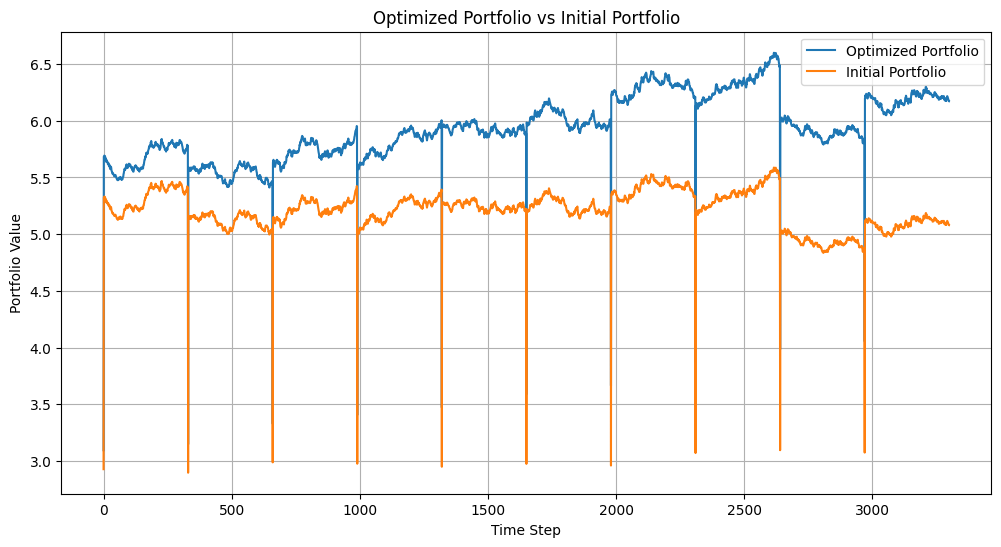

In [26]:
# After simulation, plot both portfolios
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label='Optimized Portfolio')
plt.plot(buy_and_hold_values, label='Initial Portfolio')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value')
plt.title('Optimized Portfolio vs Initial Portfolio')
plt.legend()
plt.grid(True)
plt.show()

# Create DataFrame of optimized weights
weights_df = pd.DataFrame(
    optimized_weights,
    index=timestamps[:-1],
    columns=symbols
)

In [ ]:
def run_single_day_optimization(
    close_pivot,           # 收盘价数据 (单日)
    alpha_pivot,           # alpha预测数据 (单日)
    is_limit_up_pivot,     # 涨停数据 (单日)
    is_limit_down_pivot,   # 跌停数据 (单日)
    is_st_pivot,          # ST股票数据 (单日)
    initial_weights,       # 当日初始权重
    initial_portfolio_value, # 当日初始组合价值
    max_trade_pct,         # 最大交易比例
    optimizer,             # 优化器对象
    day_timestamps = None         # 单日的时间戳列表
):
    """
    运行单日优化策略
    
    Args:
        close_pivot: 收盘价数据 (DataFrame, 单日)
        alpha_pivot: alpha预测数据 (DataFrame, 单日)
        is_limit_up_pivot: 涨停数据 (DataFrame, 单日)
        is_limit_down_pivot: 跌停数据 (DataFrame, 单日)
        is_st_pivot: ST股票数据 (DataFrame, 单日)
        initial_weights: 当日初始权重 (numpy array)
        initial_portfolio_value: 当日初始组合价值 (float)
        max_trade_pct: 最大交易比例 (float)
        optimizer: 优化器对象
        day_timestamps: 单日的时间戳列表 (list of datetime)
    
    Returns:
        dict: 包含以下键的字典
            - 'final_portfolio_value': 当日结束时的组合价值
            - 'final_weights': 当日结束时的权重
            - 'buyhold_final_value': 买入持有策略的最终价值
            - 'buyhold_final_weights': 买入持有策略的最终权重
            - 'daily_cumulative_trades': 当日累计交易量
            - 'buyhold_daily_trades': 买入持有策略的当日交易量
            - 'intraday_portfolio_values': 日内组合价值变化
            - 'intraday_weights': 日内权重变化
    """
    if day_timestamps is None:
        day_timestamps = close_pivot.index.sort_values()
        
    n_symbols = len(initial_weights)
    portfolio_value = initial_portfolio_value
    w0 = initial_weights.copy()
    
    # 初始化买入持有策略
    buyhold_value = initial_portfolio_value
    buyhold_weights = initial_weights.copy()
    
    # 日内数据记录
    intraday_portfolio_values = [portfolio_value]
    intraday_weights = [w0.copy()]
    
    # 当日累计交易量
    cumulative_trades = np.zeros(n_symbols)
    buyhold_trades = np.zeros(n_symbols)
    
    if len(day_timestamps) < 2:
        print(f"当日数据不足，跳过")
        return {
            'final_portfolio_value': portfolio_value,
            'final_weights': w0.copy(),
            'buyhold_final_value': buyhold_value,
            'buyhold_final_weights': buyhold_weights.copy(),
            'daily_cumulative_trades': cumulative_trades,
            'buyhold_daily_trades': buyhold_trades,
            'intraday_portfolio_values': intraday_portfolio_values,
            'intraday_weights': intraday_weights
        }
    
    # 处理当日每个时间点
    for i in range(len(day_timestamps) - 1):
        current_timestamp = day_timestamps[i]
        next_timestamp = day_timestamps[i + 1]
        
        # 获取当前alpha预测
        alpha = alpha_pivot.loc[current_timestamp].values
        
        # 获取当前是否ST股票或者涨跌停
        optimizable = (is_limit_up_pivot.loc[current_timestamp].values | 
                      is_limit_down_pivot.loc[current_timestamp].values | 
                      is_st_pivot.loc[current_timestamp].values)
        
        # 获取当前价格
        current_prices = close_pivot.loc[current_timestamp].values
        
        try:
            # 运行优化
            w_opt = optimizer.optimize(
                w0=w0,
                alpha=alpha,
                max_trade_pct=max_trade_pct,
                initial_weights=initial_weights,
                cumulative_trades=cumulative_trades,
                optimizable_mask=optimizable,
                current_portfolio_value=portfolio_value,
                initial_portfolio_value=initial_portfolio_value
            )
            
            # 计算交易比例
            trade_ratio = np.abs(w_opt - w0) * portfolio_value / (initial_weights * initial_portfolio_value)
            cumulative_trades += trade_ratio
            
            # 更新下一期的组合价值
            next_prices = close_pivot.loc[next_timestamp].values
            returns = (next_prices - current_prices) / current_prices
            portfolio_value *= (1 + np.dot(w_opt, returns))
            
            # 基于价格变化更新买入持有策略
            buyhold_value *= (1 + np.dot(buyhold_weights, returns))
            
            # 记录买入持有策略权重变化
            buyhold_weights = buyhold_weights * (1 + returns)
            buyhold_weights /= buyhold_weights.sum()
            
            # 计算买入持有策略交易量
            if i > 0:
                buyhold_trades += np.abs(buyhold_weights - intraday_weights[-1])
            
            # 基于价格变化更新权重
            w0 = w_opt * (1 + returns)
            w0 /= w0.sum()  # 重新归一化
            
        except ValueError as e:
            print(f"在时间 {current_timestamp} 优化失败: {str(e)}")
            w_opt = w0.copy()  # 使用当前权重作为回退
            
            # 即使优化失败，也要更新买入持有策略
            next_prices = close_pivot.loc[next_timestamp].values
            returns = (next_prices - current_prices) / current_prices
            buyhold_value *= (1 + np.dot(buyhold_weights, returns))
            buyhold_weights = buyhold_weights * (1 + returns)
            buyhold_weights /= buyhold_weights.sum()
        
        # 记录日内数据
        intraday_portfolio_values.append(portfolio_value)
        intraday_weights.append(w0.copy())
    
    return {
        'final_portfolio_value': portfolio_value,
        'final_weights': w0.copy(),
        'buyhold_final_value': buyhold_value,
        'buyhold_final_weights': buyhold_weights.copy(),
        'daily_cumulative_trades': cumulative_trades,
        'buyhold_daily_trades': buyhold_trades,
        'intraday_portfolio_values': intraday_portfolio_values,
        'intraday_weights': intraday_weights
    }

# 使用示例:
# 外层循环处理每日数据
# for date in date_range:
#     # 获取当日数据
#     day_close = close_pivot.loc[date]
#     day_alpha = alpha_pivot.loc[date]
#     day_limit_up = is_limit_up_pivot.loc[date]
#     day_limit_down = is_limit_down_pivot.loc[date]
#     day_st = is_st_pivot.loc[date]
#     day_timestamps = day_close.index.sort_values()
#     
#     # 调用单日优化函数
#     day_results = run_single_day_optimization(
#         close_pivot=day_close,
#         alpha_pivot=day_alpha,
#         is_limit_up_pivot=day_limit_up,
#         is_limit_down_pivot=day_limit_down,
#         is_st_pivot=day_st,
#         initial_weights=current_weights,  # 从上一日结果获取
#         initial_portfolio_value=current_portfolio_value,  # 从上一日结果获取
#         max_trade_pct=max_trade_pct,
#         optimizer=optimizer,
#         day_timestamps=day_timestamps
#     )
#     
#     # 更新下一日的初始值
#     current_weights = day_results['final_weights']
#     current_portfolio_value = day_results['final_portfolio_value']

In [32]:
run_single_day_optimization(
    close_pivot.iloc[:241],           # 收盘价数据 (单日)
    alpha_pivot.iloc[:241],           # alpha预测数据 (单日)
    is_limit_up_pivot.iloc[:241],     # 涨停数据 (单日)
    is_limit_down_pivot.iloc[:241],   # 跌停数据 (单日)
    is_st_pivot.iloc[:241],          # ST股票数据 (单日)
    initial_weights,       # 当日初始权重
    initial_portfolio_value, # 当日初始组合价值
    max_trade_pct,         # 最大交易比例
    optimizer,             # 优化器对象
)

{'final_portfolio_value': np.float64(11.355558348990213),
 'final_weights': array([0.04269275, 0.46732697, 0.43663299, 0.02321111, 0.03013619]),
 'buyhold_final_value': np.float64(11.206005551197139),
 'buyhold_final_weights': array([0.04326261, 0.46231595, 0.43133382, 0.02728855, 0.03579906]),
 'daily_cumulative_trades': array([2.69618509e-05, 2.43315919e-02, 2.57972487e-02, 1.38070862e-01,
        1.46976923e-01]),
 'buyhold_daily_trades': array([0.13618604, 1.19749649, 1.26601504, 0.97412004, 1.35320545]),
 'intraday_portfolio_values': [np.float64(5.844788864932019),
  np.float64(11.231735890704526),
  np.float64(11.242412997887854),
  np.float64(11.252369530568128),
  np.float64(11.242514160640766),
  np.float64(11.243788321110763),
  np.float64(11.237260778783057),
  np.float64(11.197084586049305),
  np.float64(11.207164683132172),
  np.float64(11.166763996849046),
  np.float64(11.154255652884023),
  np.float64(11.140401935592665),
  np.float64(11.177010578984515),
  np.float64(11